# Sentimentanalyse

Eine Sentimentanalyse untersucht die Stimmung oder Tonalität eines Textes, um herauszufinden, ob dieser eher positiv, negativ oder neutral ist. Diese Analyse wird häufig in der Meinungsforschung, im Marketing und in der Marktforschung eingesetzt, um Einblicke in die öffentliche Meinung und Kundenzufriedenheit zu gewinnen. Die Ergebnisse können helfen, Trends zu erkennen, Kundenfeedback zu interpretieren und strategische Entscheidungen zu unterstützen. Insgesamt bietet die Sentimentanalyse wertvolle Informationen darüber, wie Menschen über Produkte, Dienstleistungen oder Themen denken und fühlen.

Angewendet auf unser Thema haben wir uns damit befasst, ob Parteiprogramme entweder optimistisch oder pessimistisch in die Zukunft schauen. Zuerst werden, wie in der statistischen Analyse, die Wahlprogramme eingelesen.

In [1]:
# Aufsetzen der benötigten Daten
import utilities

programs = utilities.read_election_programs()
print(programs)

Lese Parteienprogramme ein...
Reading FDP_europawahlprogramm-2024_vorabversion.pdf...
Matched FDP_europawahlprogramm-2024_vorabversion.pdf to FDP
Reading AfD_Europawahlprogramm-2024-_-web.pdf...
Matched AfD_Europawahlprogramm-2024-_-web.pdf to AfD
Reading ÖDP_Programm_Europawahl2024_230224_ES.pdf...
Matched ÖDP_Programm_Europawahl2024_230224_ES.pdf to ÖDP
Reading Grüne_EU-Wahlprogramm2024_A4.pdf...
Matched Grüne_EU-Wahlprogramm2024_A4.pdf to Grüne
Reading Familien-Partei_Europawahlprogramm2024.pdf...
Matched Familien-Partei_Europawahlprogramm2024.pdf to Familien-Partei
Reading Freie-Wähler_Europawahlprogramm 2024.pdf...
Matched Freie-Wähler_Europawahlprogramm 2024.pdf to Freie-Wähler
Reading BSW_Europawahlprogramm_2024.pdf...
Matched BSW_Europawahlprogramm_2024.pdf to BSW
Reading cdu-csu_europawahlprogramm-2024_0.pdf...
Matched cdu-csu_europawahlprogramm-2024_0.pdf to cdu-csu
Reading Buendnis-Deutschland_europawahl-a5-doppelseiten-digital.pdf...
Matched Buendnis-Deutschland_europawahl-

Für die Sentimentanalyse wird nun ein vortrainiertes BERT-Modell und seine Tokenizer geladen.Der Tokenizer zerlegt den Text in Token, die das Modell versteht. Wir haben uns für drei Sentimentklassen (negativ, neutral, positiv) entschieden. 

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

model_name = "MarieAngeA13/Sentiment-Analysis-BERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, force_download=True)

/Users/jonas/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jonas/.pyenv/versions/3.10.0/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/jonas/.pyenv/versions/3.10.0/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Zur genaueren Betrachtung des Modells wird es dem Benutzer einmal ausgegeben.

In [3]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Zunächst wird eine Pipeline für die Sentimentanalyse erstellt, die das zuvor geladene Modell und den Tokenizer verwendet. Diese Pipeline vereinfacht die Anwendung des Modells auf Texte und kümmert sich um die Tokenisierung, die Modellvorhersage und die Interpretation der Ergebnisse.

Mit Hilfe dieser Pipeline werden numerische Werte für die Text-Abschnitte generiert.

In [4]:
import torch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import statistics

def sentiment_analyzer(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.softmax(outputs.logits, dim=1).tolist()

# Function to split text into chunks of specified token length
def split_into_chunks(text, tokenizer, max_length):
    tokens = tokenizer.tokenize(text)
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    return [tokenizer.convert_tokens_to_string(chunk) for chunk in chunks]

sentiment_ergebnisse = []

# Process each program
for party, program in programs.items():
    chunks = split_into_chunks(program, tokenizer, max_length=512)
    results = [sentiment_analyzer(chunk) for chunk in chunks]
    print(f"Party {party} analysed.")

    # Flattening the results properly
    flattened_results = [score for result in results for sublist in result for score in sublist]

    sentiment_ergebnisse.append({
        'party': party,
        'results': flattened_results
    })

def calculate_statistics(results):
    # Ensure the results are floats
    float_results = [float(result) for result in results]
    return {
        'average': statistics.mean(float_results),
        'max': max(float_results),
        'min': min(float_results),
        'count': len(float_results),
        'median': statistics.median(float_results),
        'stdev': statistics.stdev(float_results) if len(float_results) > 1 else 0  # Standard deviation
    }

statistics_list = []

for item in sentiment_ergebnisse:
    party = item['party']
    results = item['results']
    stats = calculate_statistics(results)
    statistics_list.append({'party': party, 'statistics': stats})

for item in statistics_list:
    print(f"Party: {item['party']}")
    for stat_name, stat_value in item['statistics'].items():
        print(f"  {stat_name}: {stat_value:.4f}")
    print()



Token indices sequence length is longer than the specified maximum sequence length for this model (24526 > 512). Running this sequence through the model will result in indexing errors


Party FDP analysed.
Party AfD analysed.
Party ÖDP analysed.
Party Grüne analysed.
Party Familien-Partei analysed.
Party Freie-Wähler analysed.
Party BSW analysed.
Party cdu-csu analysed.
Party Buendnis-Deutschland analysed.
Party Tierschutzpartei analysed.
Party Linke analysed.
Party Die-Piraten analysed.
Party Die-Partei analysed.
Party SPD analysed.
Party Volt analysed.
Party: FDP
  average: 0.3333
  max: 0.7753
  min: 0.0663
  count: 144.0000
  median: 0.1751
  stdev: 0.2777

Party: AfD
  average: 0.3333
  max: 0.8341
  min: 0.0496
  count: 312.0000
  median: 0.1594
  stdev: 0.2809

Party: ÖDP
  average: 0.3333
  max: 0.8492
  min: 0.0524
  count: 198.0000
  median: 0.1605
  stdev: 0.2938

Party: Grüne
  average: 0.3333
  max: 0.9001
  min: 0.0307
  count: 927.0000
  median: 0.1705
  stdev: 0.2782

Party: Familien-Partei
  average: 0.3333
  max: 0.8014
  min: 0.0708
  count: 84.0000
  median: 0.1670
  stdev: 0.2875

Party: Freie-Wähler
  average: 0.3333
  max: 0.8086
  min: 0.0554
 

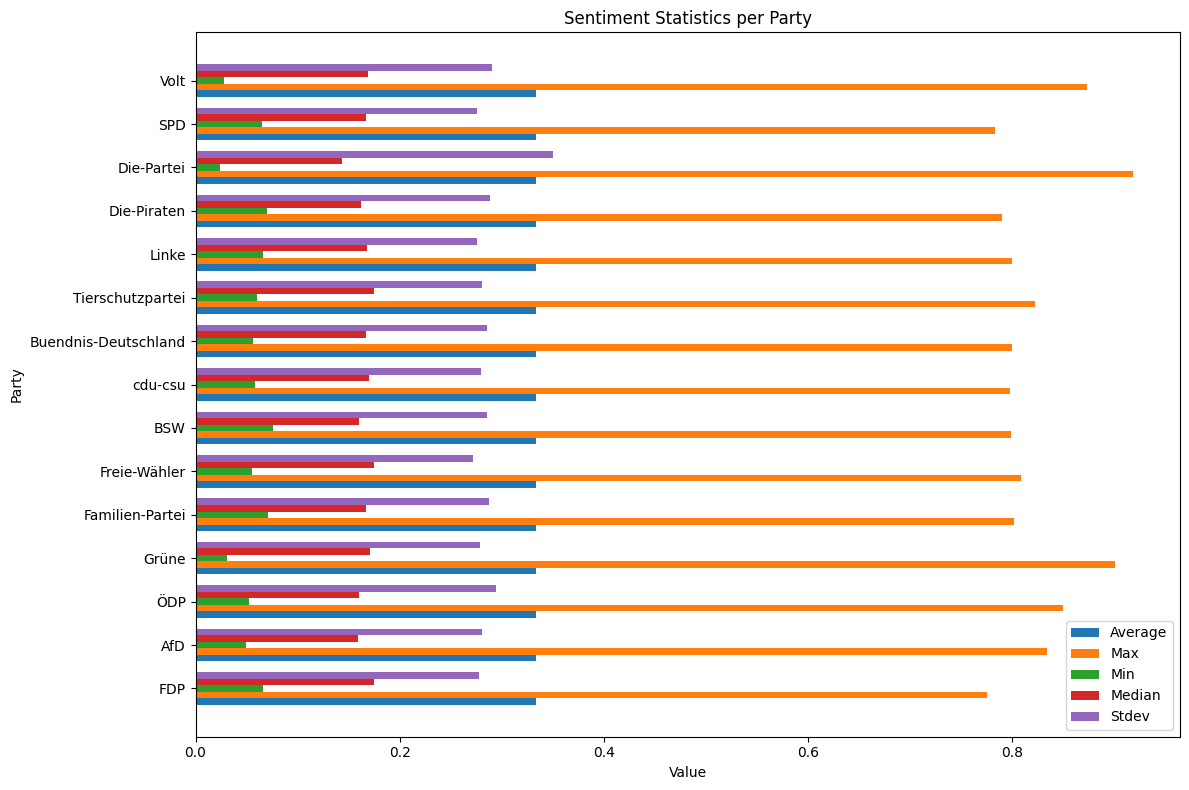

In [5]:
parties = [item['party'] for item in statistics_list]
averages = [item['statistics']['average'] for item in statistics_list]
max_values = [item['statistics']['max'] for item in statistics_list]
min_values = [item['statistics']['min'] for item in statistics_list]
medians = [item['statistics']['median'] for item in statistics_list]
stdevs = [item['statistics']['stdev'] for item in statistics_list]

bar_width = 0.15
x = np.arange(len(parties))

fig, ax = plt.subplots(figsize=(12, 8))

bars1 = ax.barh(x - 2*bar_width, averages, bar_width, label='Average')
bars2 = ax.barh(x - bar_width, max_values, bar_width, label='Max')
bars3 = ax.barh(x, min_values, bar_width, label='Min')
bars4 = ax.barh(x + bar_width, medians, bar_width, label='Median')
bars5 = ax.barh(x + 2*bar_width, stdevs, bar_width, label='Stdev')

ax.set_ylabel('Party')
ax.set_xlabel('Value')
ax.set_title('Sentiment Statistics per Party')
ax.set_yticks(x)
ax.set_yticklabels(parties)
ax.legend()

plt.tight_layout()
plt.show()

## Fazit

Die Sentimentanalyse zeigt keine großen Unterschiede zwischen den Parteien, lässt aber einen Grundtenor erkennen. Wahlprogramme sind grundsätzlich eher negativ geschrieben, da Probleme angesprochen werden, die es in der nächsten Legislaturperiode zu lösen gilt. 